<a href="https://colab.research.google.com/github/sjosephnyc1987/public_ipython_Notebooks/blob/main/DAL_FXXP_TickData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#initializations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

#this is a terrible practice and dont do it
import warnings
warnings.filterwarnings("ignore")


Mounted at /content/drive


In [ ]:
filepath = "/content/drive/MyDrive/TEMPO/datasets/FXXP_Tick_Data.csv"

df2 = pd.read_csv(filepath,sep='\t', header=0)

original_size = len(df2)
print("original dataframe size = ", original_size)

#Let's look at the first 10 rows
print(df2.head(10))

original dataframe size =  7930
                    Id  Index Type              TimestampUtc  Size  Value
0 -9223372033721472385      1  Bid  20101203 08:01:34.731600     0  270.0
1 -9223372033721472373      2  Ask  20101203 08:08:42.914736    40  272.4
2 -9223372033721472367      3  Bid  20101203 08:09:08.806047    40  271.1
3 -9223372033721472365      4  Bid  20101203 08:09:11.579957    40  271.1
4 -9223372033721472363      5  Ask  20101203 08:09:13.882389    40  272.3
5 -9223372033721472361      6  Ask  20101203 08:09:14.755620    40  272.2
6 -9223372033721472360      7  Bid  20101203 08:09:14.755620     0  271.0
7 -9223372033721472355      8  Bid  20101203 08:09:24.586466    80  270.8
8 -9223372033721472354      9  Ask  20101203 08:09:24.855967    40  272.1
9 -9223372033721472353     10  Bid  20101203 08:09:24.855967    40  270.9


In [ ]:
#next let's see if there are any nulls and if so we should remove them
df2.isnull().sum()

Id              0
Index           0
Type            0
TimestampUtc    0
Size            0
Value           0
dtype: int64

In [ ]:
#There appear to be some lots with Size of 0 and Negative, let's remove those and assign to a new dataframe df2_Size0_Removed
#as they appear to be artefacts
df2_Size0_Removed = df2[df2['Size']>0]

In [ ]:
#Let's look at the first 10 rows again
print(df2_Size0_Removed.head(10))

                     Id  Index Type              TimestampUtc  Size  Value
1  -9223372033721472373      2  Ask  20101203 08:08:42.914736    40  272.4
2  -9223372033721472367      3  Bid  20101203 08:09:08.806047    40  271.1
3  -9223372033721472365      4  Bid  20101203 08:09:11.579957    40  271.1
4  -9223372033721472363      5  Ask  20101203 08:09:13.882389    40  272.3
5  -9223372033721472361      6  Ask  20101203 08:09:14.755620    40  272.2
7  -9223372033721472355      8  Bid  20101203 08:09:24.586466    80  270.8
8  -9223372033721472354      9  Ask  20101203 08:09:24.855967    40  272.1
9  -9223372033721472353     10  Bid  20101203 08:09:24.855967    40  270.9
10 -9223372033721472349     11  Bid  20101203 08:09:55.698155    80  270.8
11 -9223372033721472347     12  Bid  20101203 08:10:03.673333    80  270.8


Entries of Index 7 and 1 from the first 10 rows had size 0, they seem to be gone and so we're on the right track

In [ ]:
#we do a sanity check and look at the lenght of the dataframe now
print("current dataframe size = ", len(df2_Size0_Removed))
print("entries removed = ", original_size - len(df2_Size0_Removed))

current dataframe size =  6125
entries removed =  1805


In [ ]:
#next we look for bad instruction types and remove them if needed
print(df2_Size0_Removed['Type'].value_counts())

Ask      3361
Bid      2741
Trade      22
I           1
Name: Type, dtype: int64


We see a Type of "I" (and others) and so we remove them

In [ ]:
df2_inst_Removed = df2_Size0_Removed[(df2_Size0_Removed['Type']=="Bid") | (df2_Size0_Removed['Type']=="Ask") | (df2_Size0_Removed['Type']=="Trade")]

In [ ]:
#let's look at the lenght of the dataframe now
print(len(df2_inst_Removed))
print("--------")

#and the valuecounts again
print(df2_inst_Removed['Type'].value_counts())

6124
--------
Ask      3361
Bid      2741
Trade      22
Name: Type, dtype: int64


In [ ]:
#for ease of handling we assign it to df3
df3 = df2_inst_Removed.copy()

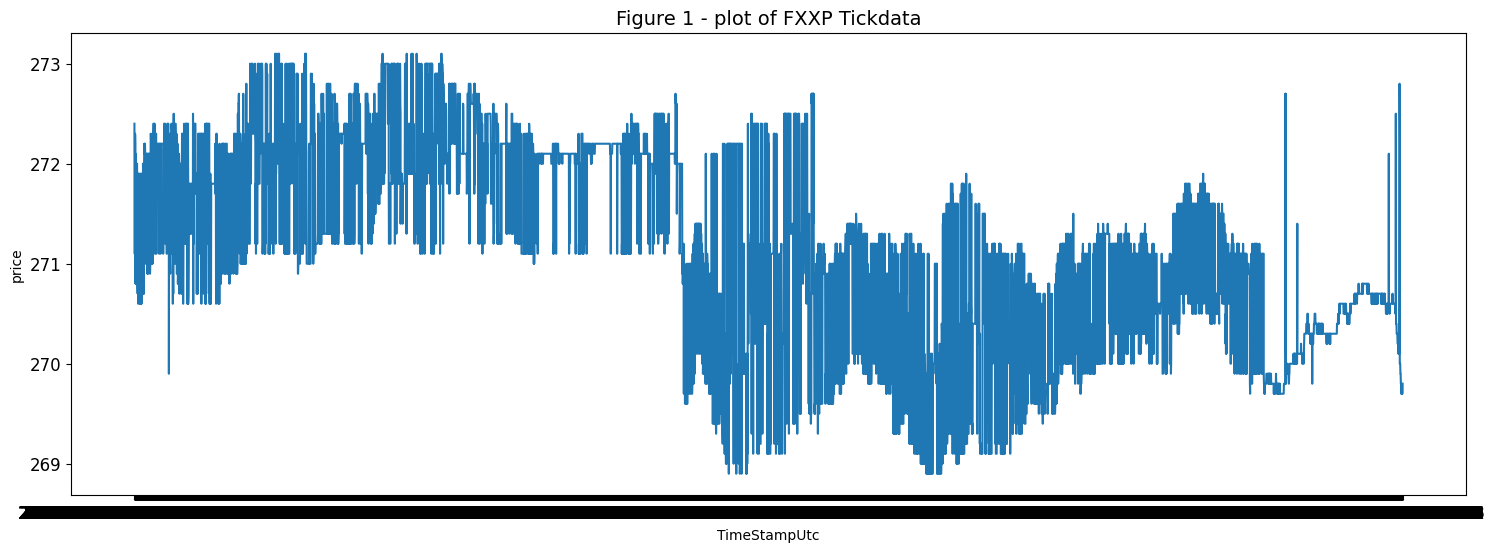

In [ ]:
#Next we plot this data to get a visual impression

# Extract the date and close price columns
timestamp = df3['TimestampUtc']
price = df3['Value']

# Create a line plot
plt.plot(timestamp, price)
#plt.scatter(portfolio_vol,portfolio_exp_returns, c="hotpink")
plt.xlabel("TimeStampUtc", fontsize=10)
plt.ylabel("price", fontsize=10)
plt.title(f"Figure 1 - plot of FXXP Tickdata",fontsize =14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.rcParams['figure.figsize'] = [18, 6]

# Show the plot
plt.show()

We see some outliers, so we try an use a threshold to remove the data
**------------- tdl ----- add more here**

Although there is some overlap in Bid and Offer prices, not separating them will cause good quotes to drop out and so we separate the Bids, Asks and Trades before we do the comparison to the rolling media

In [ ]:
#separating  the bids and offers
df3_bid = df3[df3['Type']=='Bid']
df3_ask = df3[df3['Type']=='Ask']
df3_trade = df3[df3['Type']=='Trade']

In [ ]:
df3_bid['rolling_std_10']=df3_bid['Value'].rolling(10).std()
df3_ask['rolling_std_10']=df3_ask['Value'].rolling(10).std()
df3_trade['rolling_std_10']=df3_trade['Value'].rolling(10).std()

df3_bid['rolling_mean_10']=df3_bid['Value'].rolling(10).mean()
df3_ask['rolling_mean_10']=df3_ask['Value'].rolling(10).mean()
df3_trade['rolling_mean_10']=df3_trade['Value'].rolling(10).mean()